# Explainable Artificial Intelligence

We will try to explain why the model made a specific prediction on some examples

In [1]:
import pickle
import dalex as dx # XAI library
import matplotlib.pyplot as plt
%matplotlib inline
import scikitplot as skplt
import pandas as pd
import numpy as np
np.random.seed(1)

In [2]:
train_data = pd.read_csv('../Data/preprocessed2-train-bank-data.csv', sep=';')
test_data = pd.read_csv('../Data/preprocessed2-test-bank-data.csv', sep=';')

train_data.head()

,age,campaign,contacted.in.previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,...,contact_cellular,contact_telephone,poutcome_failure,poutcome_nonexistent,poutcome_success,month_sin,month_cos,day_sin,day_cos,y
0,0.322632,1.000000,0.0,1.000000,0.612813,0.390735,0.970664,1.000000,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,-0.500000,-0.866025,-5.877853e-01,-0.809017,0.0
1,0.552137,0.000000,0.0,1.000000,0.422695,0.724448,0.970664,1.000000,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-0.866025,-0.500000,-9.510565e-01,0.309017,0.0
2,0.636314,0.495659,0.0,0.854914,0.644951,0.710269,0.932652,0.710922,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.500000,-0.866025,-2.449294e-16,1.000000,0.0
3,0.798640,0.000000,0.0,0.432174,0.331438,0.428275,0.714556,0.743803,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,-0.500000,0.866025,9.510565e-01,0.309017,0.0
4,0.552137,0.495659,0.0,1.000000,0.612813,0.390735,0.970309,1.000000,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-0.500000,-0.866025,-9.510565e-01,0.309017,0.0


In [3]:
X_train, y_train = train_data.drop('y', axis=1), train_data['y']
X_test, y_test = test_data.drop('y', axis=1), test_data['y']

In [4]:
"""Loading pickled Random Forest Model"""
file = open('../Models/Serialized_models/random_forest_classifier_gs.pickle', 'rb')
rfc = pickle.load(file)
file.close()

print(rfc)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=3, n_estimators=80,
                       random_state=1)


In [5]:
explainer = dx.Explainer(rfc, X_test, y_test)

Preparation of a new explainer is initiated

  -> data              : 7975 rows 43 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 7975 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000029C20498828> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.135, mean = 0.369, max = 0.977
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.974, mean = -0.26, max = 0.844
  -> model_info        : package sklearn

A new explainer has been created!


c:\Users\frane\anaconda3\envs\kaggleproject\lib\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


# Example Shap plots

In [6]:
examples = np.random.randint(low=0,high=X_test.shape[0]-1,size=4)

for i in examples:
    shap = explainer.predict_parts(X_test.loc[i], type='shap', B=44)
    shap.plot()

Shap plots can help us understand why model made a specific prediction in the case. It shows which features had a biggest impact on a classification and was the impact positive or negative.

# Ceteris paribus plots
It shows average probability prediction for individual variable.

In [7]:
pdp = explainer.model_profile()
pdp.plot()

Calculating ceteris paribus: 100%|██████████| 43/43 [00:06<00:00,  6.78it/s]


# Feature importance in the model

In [8]:
permutation_importance = explainer.model_parts(loss_function='rmse')
permutation_importance.plot()

# Lift and Gain curves
- Lift curve shows how many times better it is to use a model than a random choice

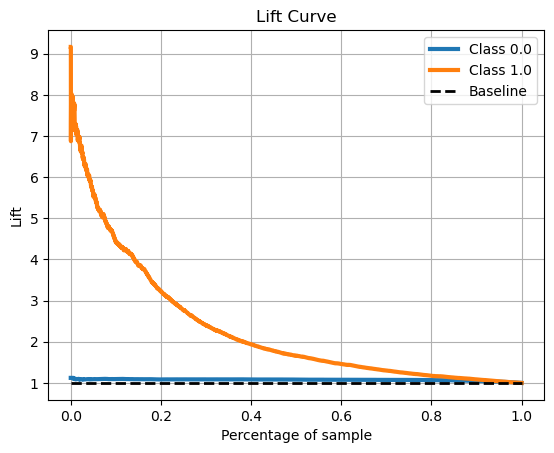

In [9]:
skplt.metrics.plot_lift_curve(y_test, rfc.predict_proba(X_test))
plt.legend(loc='upper right')
plt.show()

For example, we see that contacting customers with the top 20% predicted probabilities is more than 3 times better than randomly selecting them.

- Cumulative Gains curve shows the percentage of targets reached when considering a certain percentage of the population with the highest probabilities predicted by the model

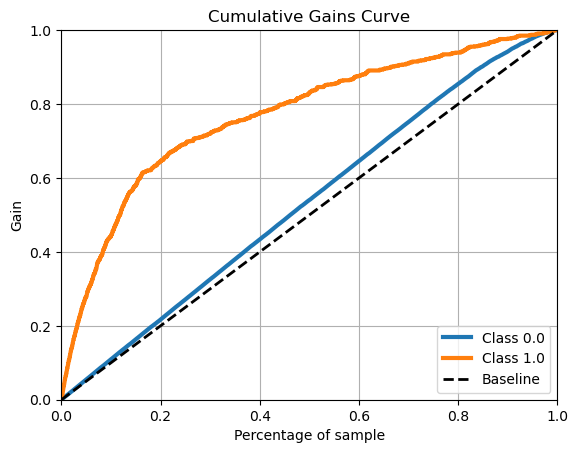

In [10]:
skplt.metrics.plot_cumulative_gain(y_test, rfc.predict_proba(X_test))
plt.legend(loc='lower right')
plt.show()

In our case it shows how many responders will we reach after contacting some ammount of all of the customers with the highest predicted probabilities.

For example after contacting customers with top 20% predicted probabilities, we will reach over 60% of customers that will place the advertised deposit.